# Goods description for interner store

The online store "WikiShop" is launching a new service. Now users can edit and add product descriptions, similar to how it works in wiki communities. This means that customers can suggest their edits and comment on changes made by others. The store needs a tool that will identify toxic comments and send them for moderation.

The goal of this project is to train a model to classify comments as positive or negative. F1 score of the model must be at least 0.75 for evaluation.

The data is located in the toxic_comments.csv file. The "text" column contains the comment text, and "toxic" is the target variable indicating toxicity.

## Preliminary Data Analysis 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sn

from nltk.corpus import stopwords as nltk_stopwords
import re
from tqdm import tqdm

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv   
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

from pymystem3 import Mystem
import spacy

import warnings
warnings.filterwarnings('ignore')

2023-09-04 20:26:56.050746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('/Users/mojseenkodenis/Desktop/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

It is possible to notice that the features are not balanced: there are more positive comments than negative ones.

In [6]:
#Converting the entire text to lowercase
data['text'] = data['text'].str.lower()

There might be a correlation between the length of a comment and its toxicity, so let's check if it's worth adding the length as a feature.

In [7]:
df = data.copy()
df['length'] = df['text'].apply(len)

In [8]:
df.head()

,Unnamed: 0,text,toxic,length
0,0,explanation\nwhy the edits made under my usern...,0,264
1,1,d'aww! he matches this background colour i'm s...,0,112
2,2,"hey man, i'm really not trying to edit war. it...",0,233
3,3,"""\nmore\ni can't make any real suggestions on ...",0,622
4,4,"you, sir, are my hero. any chance you remember...",0,67


In [9]:
non_toxic = df.query('toxic != 1')
toxic = df.query('toxic == 1')

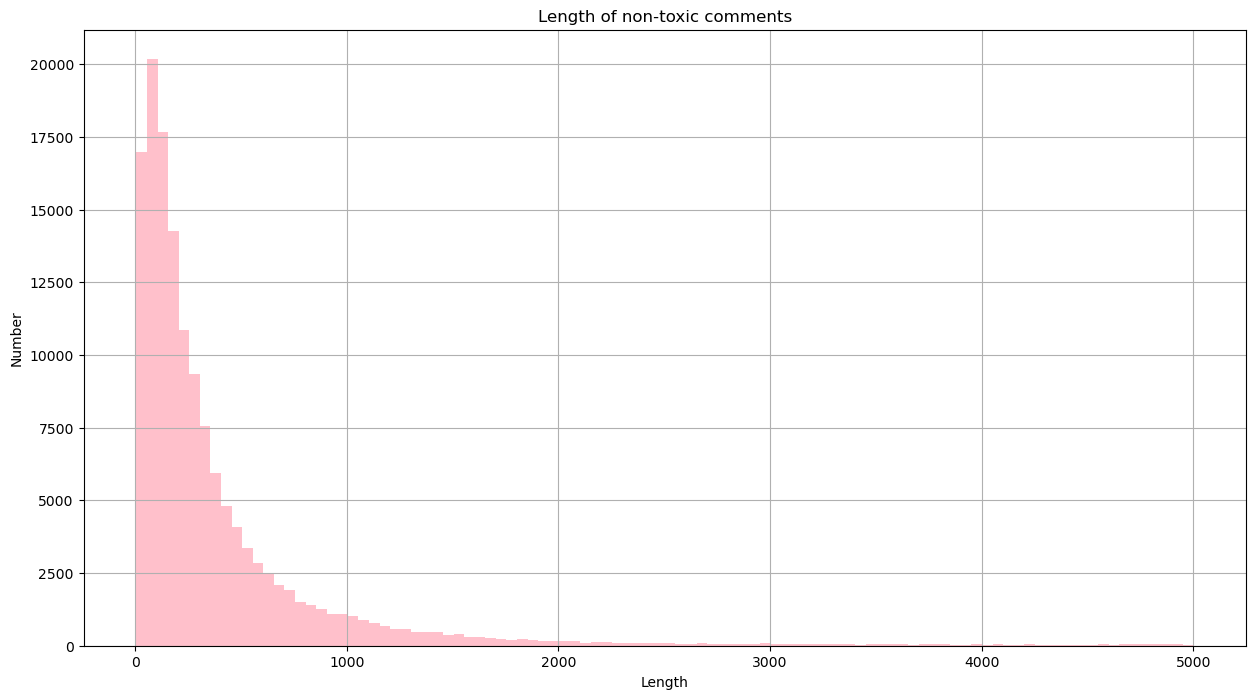

In [13]:
plt.figure(figsize=(15, 8))
non_toxic['length'].hist(color='pink', bins=100);
plt.title('Length of non-toxic comments')
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()

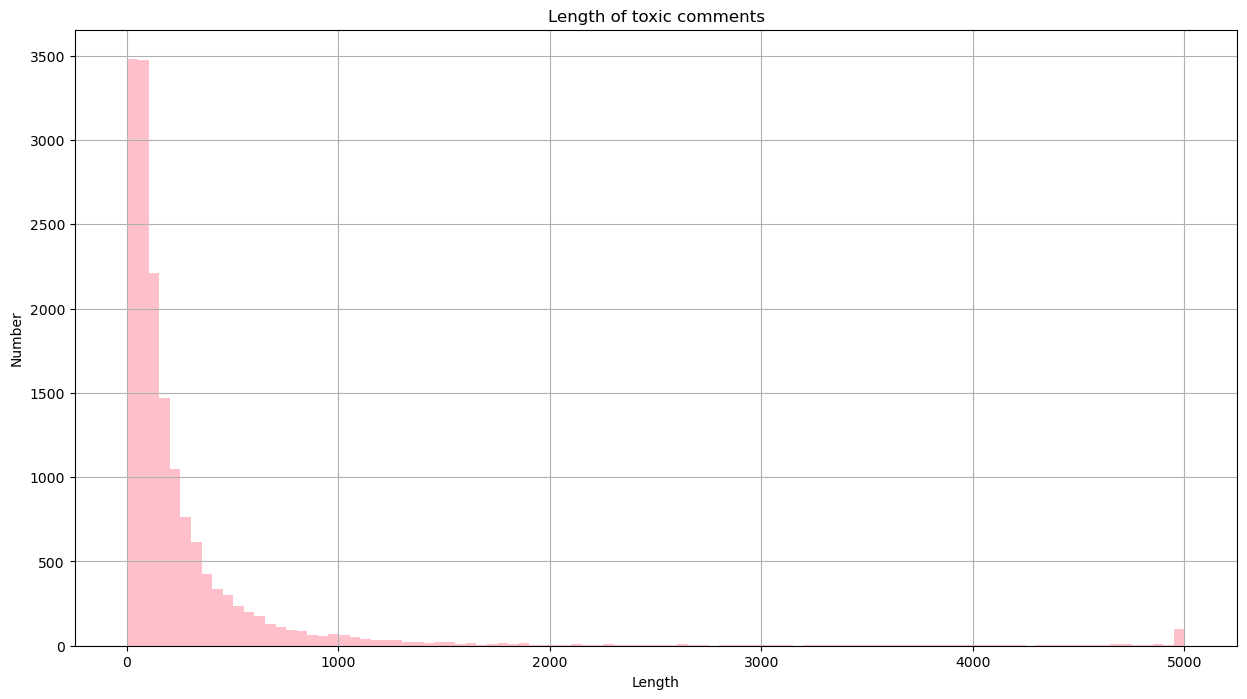

In [14]:
plt.figure(figsize=(15, 8))
toxic['length'].hist(color='pink', bins=100);
plt.title('Length of toxic comments')
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()

In [15]:
correlation = df['toxic'].corr(df['length'], method='spearman')
print(f'The correlation coefficient is equal to {correlation}')

The correlation coefficient is equal to -0.12435968326319405


The analysis of the length of positive and negative comments showed that they have a similar distribution, which is left-skewed. This means that most comments are short, regardless of their toxicity. 

Moreover, the correlation coefficient between the two features is -0.124. Therefore, there is no significant relationship between the length of a comment and its toxicity, and it will not be used as a feature in model training.

In [16]:
nlp = spacy.load('en_core_web_lg')

In [17]:
def clear_text(text):
    clear_words = re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()
    clear_text = " ".join(clear_words)
    return clear_text

In [18]:
def lemmatize(text):
    lemm = nlp(text)
    return ' '.join([token.lemma_ for token in lemm if token.lemma_.lower() not in nlp.Defaults.stop_words])

In [19]:
tqdm.pandas()
data['clear_text'] = data['text'].progress_apply(clear_text)

100%|██████████| 159292/159292 [00:07<00:00, 22282.67it/s]


In [20]:
data['lemmatized_text'] = data['clear_text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [1:01:09<00:00, 43.41it/s]


In [21]:
data.head()

,Unnamed: 0,text,toxic,clear_text,lemmatized_text
0,0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,d aww match background colour m seemingly stuc...
2,2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,hey man m try edit war s guy constantly remove...
3,3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,t real suggestion improvement wonder section s...
4,4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero chance remember page s


In [22]:
stopwords = set(nltk_stopwords.words('english'))

In the first stage, the data was explored, and the text was converted to lowercase. It was checked whether the comment's length is related to its toxicity, and in the end, no correlation was found.

Also, a class imbalance was detected: there are more positive comments than negative ones.

In the end, text data was cleaned and lemmatized.

## Model trainig

In [23]:
target = data['toxic']
features = data['lemmatized_text']

In [25]:
#Splitting the dataset into training, validation, and test sets in a 60%-20%-20% ratio
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                                                                        target, 
                                                                                        test_size=0.4, 
                                                                                        random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            test_size=0.5, random_state=12345)
print('Training set: ', features_train.shape[0] / features.shape[0] * 100)
print('Validation set: ', features_valid.shape[0] / features.shape[0] * 100)
print('Test set: ', features_test.shape[0] / features.shape[0] * 100)

Training set:  59.99987444441655
Validation set:  19.999748888833086
Test set:  20.00037666675037


### Logistic Regression

In [26]:
pipeline = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(random_state=12345)),
])
parameters = {
    'logreg__C': [0.001, 0.1, 1, 10]
}

grid_search_tune = RandomizedSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune.fit(features_train, target_train)

best_model_reg = grid_search_tune.best_estimator_
predictions_reg = best_model_reg.predict(features_valid)
f1_score_reg = f1_score(target_valid, predictions_reg)
print(f'F1-score for logistic regression: {f1_score_reg}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
F1-score for logistic regression: 0.7617670682730923


### Decision Tree

In [27]:
pipeline_tree = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('dtree', DecisionTreeClassifier(random_state=12345)),
])
parameters = {
    'dtree__max_depth': list(range(2, 20, 2))
}

grid_search_tune_tree = RandomizedSearchCV(pipeline_tree, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune_tree.fit(features_train, target_train)

best_model_tree = grid_search_tune_tree.best_estimator_
print(best_model_tree)
predictions_tree = best_model_tree.predict(features_valid)
f1_score_tree = f1_score(target_valid, predictions_tree)
print(f'F1-score for decision tree: {f1_score_tree}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Pipeline(steps=[('count', CountVectorizer(stop_words='english')),
                ('dtree',
                 DecisionTreeClassifier(max_depth=18, random_state=12345))])
F1-score for decision tree: 0.649016641452345


### Random Forest

In [29]:
pipeline_forest = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('forest', RandomForestClassifier(random_state=12345))])
parameters = {
    'forest__max_depth': list(range(2, 20, 2)),
    'forest__n_estimators': [100, 500, 1000]
}

grid_search_tune_forest = RandomizedSearchCV(pipeline_forest, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune_forest.fit(features_train, target_train)

best_model_forest = grid_search_tune_forest.best_estimator_
print(best_model_forest)
predictions_forest = best_model_forest.predict(features_valid) 
f1_score_forest = f1_score(target_valid, predictions_forest)
print(f'F1-score for random forest: {f1_score(target_valid, predictions_forest)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Pipeline(steps=[('count', CountVectorizer(stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_depth=18, random_state=12345))])
F1-score for random forest: 0.0018088634308109737


### CatBoost

In [39]:
pipeline_cat = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('cat', CatBoostClassifier(random_state=12345, verbose=False)),
])

grid_search_tune_cat = RandomizedSearchCV(pipeline_cat, {}, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune_cat.fit(features_train, target_train)

best_model_cat = grid_search_tune_cat.best_estimator_
predictions_cat = best_model_cat.predict(features_valid)
f1_score_cat = f1_score(target_valid, predictions_cat)
print(f'F1-score for CatBoost: {f1_score_cat}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..................................., score=0.713 total time=11.5min
[CV 2/3] END ..................................., score=0.711 total time=11.5min
[CV 3/3] END ..................................., score=0.710 total time=11.5min
F1-score for CatBoost: 0.7233351380617218


In [41]:
scores = [['Logistical regression', f1_score_reg],
         ['CatBoost', f1_score_cat],
         ['Desicision tree', f1_score_tree],
         ['Random forest', f1_score_forest]]

scores_show = pd.DataFrame(scores, columns=['Model', 'F1-score'])
scores_show = scores_show.set_index('Model')
scores_show

,F1-score
Model,
Logistical regression,0.761767
CatBoost,0.723335
Desicision tree,0.649017
Random forest,0.001809


Now let's try to train models without class imbalance.

### Logistic regression without imbalance

In [42]:
pipeline_oversampling = imbPipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('oversampling', RandomOverSampler(random_state=12345)),
    ('logreg', LogisticRegression(random_state=12345))])


parameters = {
    'logreg__C': [0.001, 0.1, 1, 10]
}

grid_search_tune = HalvingGridSearchCV(pipeline_oversampling, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tune.fit(features_train, target_train)

print(f"Best score: {abs(grid_search_tune.best_score_)}, Best params: {grid_search_tune.best_params_}")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 31858
max_resources_: 95575
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 31858
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 95574
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.7559577224058218, Best params: {'logreg__C': 1}


### Decision tree without imbalance

In [43]:
pipeline_oversampling_tree = imbPipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('oversampling', RandomOverSampler(random_state=12345)),
    ('dtree', DecisionTreeClassifier(random_state=12345))])


parameters = {
    'dtree__max_depth': list(range(2, 20, 2))
}

grid_search_tree = HalvingGridSearchCV(pipeline_oversampling_tree, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_tree.fit(features_train, target_train)

print(f"Best score: {abs(grid_search_tree.best_score_)}, Best params: {grid_search_tree.best_params_}")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 10619
max_resources_: 95575
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 10619
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 31857
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 1
n_resources: 95571
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.6325629974544879, Best params: {'dtree__max_depth': 18}


### Random forest without imbalance

In [44]:
pipeline_oversampling_forest = imbPipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('oversampling', RandomOverSampler(random_state=12345)),
    ('forest', RandomForestClassifier(random_state=12345))])


parameters = {
    'forest__max_depth': list(range(2, 20, 2)),
    'forest__n_estimators': [100, 500, 1000]
}

grid_search_forest = HalvingGridSearchCV(pipeline_oversampling_forest, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=3)
grid_search_forest.fit(features_train, target_train)

print(f"Best score: {abs(grid_search_forest.best_score_)}, Best params: {grid_search_forest.best_params_}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3539
max_resources_: 95575
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 3539
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 9
n_resources: 10617
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 31851
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 1
n_resources: 95553
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .logreg__C=0.1;, score=(train=0.887, test=0.724) total time=   4.7s
[CV 2/3] END ...logreg__C=1;, score=(train=0.969, test=0.733) total time=   5.2s
[CV 3/3] END ..logreg__C=10;, score=(train=0.996, test=0.729) total time=   5.3s
[CV 2/3] END .logreg__C=0.1;, score=(train=0.862, test=0.747) total time=  16.6s
[CV 1/3] END dtree__max_depth=2;, score=(train=0.343, test=0.327) total 

/Users/mojseenkodenis/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mojseenkodenis/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Best score: 0.4124523621775585, Best params: {'forest__max_depth': 18, 'forest__n_estimators': 1000}


Fighting class imbalance did not lead to an increase in the F1 metric, so we will use the logistic regression model with class imbalance for testing, which showed the best result at 0.761.

## Testing the model

In [46]:
pipeline_test = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(random_state=12345, C=10)),
])

pipeline_test.fit(features_train, target_train)
predictions_test = pipeline_test.predict(features_test)
f1_score_reg = f1_score(target_test, predictions_test)
print(f'F1-score on the test set: {f1_score_reg}')

F1-score on the test set: 0.7543713572023313


The logistic regression model on the test set achieved an F1-score of 0.754, which is in line with the specified threshold (0.75). Therefore, this model is recommended for implementation in the internet store.

## Conclusion

The goal of this project was to create a model that can classify comments as positive or negative based on their toxicity. The model is supposed to be implemented in the internet store. 

The following steps were taken:
 - Data exploration: The data was initially explored, and a class imbalance issue was identified
 - Data preprocessing: Text data was cleaned and lemmatized to prepare it for modeling
 - Model training: Four models were trained - logistic regression, decision tree, random forest, and CatBoost. These models were trained both with and without addressing class imbalance.
 - Model evaluation: The logistic regression model with class imbalance achieved the best result with an F1-score of 0.761 on the training set and 0.754 on the test set.

In conclusion, the logistic regression model with class imbalance is recommended for implementation as it performed well in classifying comments as positive or negative. The model is well equiped to recognize the stop words and send the comments deemed as toxic for the further moderation.